In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [190]:
arx = "cap_parasita_10MHz.txt"

df = pd.read_csv(arx, sep='\s+', header=None, skiprows=1, names=['time', 'Vin','Vout'])

print(df.dtypes)

df.head()

time    float64
Vin     float64
Vout    float64
dtype: object


,time,Vin,Vout
0,0.000000e+00,0.000000,0.000000
1,7.443150e-11,0.000035,0.007443
2,1.488630e-10,0.000136,0.014886
3,2.232945e-10,0.000304,0.022329
4,2.977260e-10,0.000538,0.029773


In [191]:
arx = "cap_parasita_32MHz.txt"

df2 = pd.read_csv(arx, sep='\s+', header=None, skiprows=1, names=['time', 'Vin','Vout'])

print(df2.dtypes)

df2.head()

time    float64
Vin     float64
Vout    float64
dtype: object


,time,Vin,Vout
0,0.000000e+00,0.000000,0.000000
1,3.194648e-11,0.000042,0.010649
2,6.389296e-11,0.000167,0.021298
3,9.583944e-11,0.000374,0.031946
4,1.277859e-10,0.000663,0.042595


In [206]:
arx = "cap_parasita_60MHz.txt"

df3 = pd.read_csv(arx, sep='\s+', header=None, skiprows=1, names=['time', 'Vin','Vout'])

print(df3.dtypes)

df3.head()

time    float64
Vin     float64
Vout    float64
dtype: object


,time,Vin,Vout
0,0.000000e+00,0.000000,0.000000
1,3.933236e-11,0.000123,0.024583
2,7.866471e-11,0.000478,0.049165
3,1.179971e-10,0.001066,0.073748
4,1.573294e-10,0.001885,0.098331


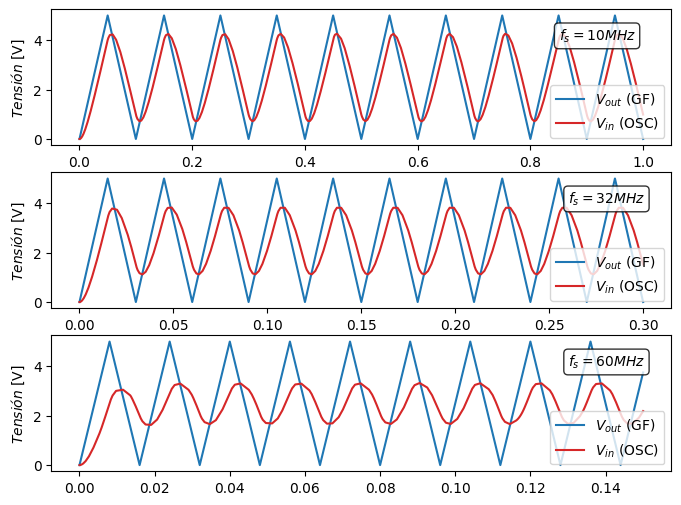

In [ ]:
fig, ax = plt.subplots(3,1, figsize=(8,6) )

ax[0].plot( (10**6)*df.time, df.Vout, c='C0', label="$V_{out}$ (GF)"  )
ax[0].plot( (10**6)*df.time, df.Vin, c='C3', label="$V_{in}$ (OSC)"  )
ax[0].text(0.85, 4, "$f_s = 10 MHz$", bbox=dict(facecolor='white', boxstyle='round,pad=0.3', alpha=0.8))

ax[1].plot( (10**6)*df2.time, df2.Vout, c='C0', label="$V_{out}$ (GF)"   )
ax[1].plot( (10**6)*df2.time, df2.Vin, c='C3', label="$V_{in}$ (OSC)"   )
ax[1].text(0.26, 4, "$f_s = 32 MHz$", bbox=dict(facecolor='white', boxstyle='round,pad=0.3', alpha=0.8))

ax[2].plot( (10**6)*df3.time, df3.Vout, c='C0', label="$V_{out}$ (GF)"   )
ax[2].plot( (10**6)*df3.time, df3.Vin, c='C3', label="$V_{in}$ (OSC)"   )
ax[2].text(0.13, 4, "$f_s = 60 MHz$", bbox=dict(facecolor='white', boxstyle='round,pad=0.3', alpha=0.8))


ax[1].set_xlabel("tiempo [$\mu$s]", fontsize=14)
ax[0].set_ylabel("$Tensión$ [V]")
ax[1].set_ylabel("$Tensión$ [V]")
ax[2].set_ylabel("$Tensión$ [V]")

ax[0].legend(loc=4)
ax[1].legend(loc=4)
ax[2].legend(loc=4)

plt.savefig("vin_vout.jpg", dpi=300)
plt.show()

## Aplicacion del filtro


In [193]:
from scipy.fft import fft, ifft

estudio uniformidad de eje temporal

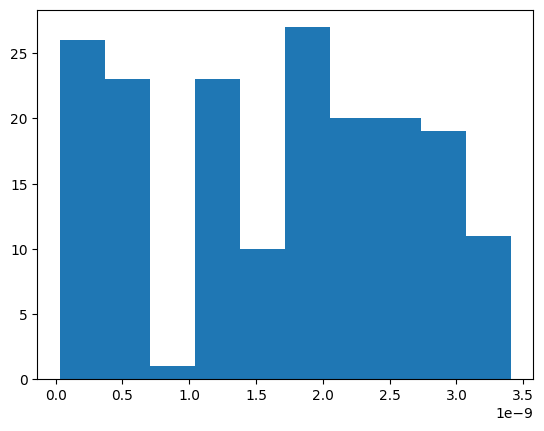

In [194]:
t = df2.time.to_numpy()
X=[]

for i in range(len(t)-1):
    X.append( t[i+1]-t[i] )


fig,ax = plt.subplots()
ax.hist( X )
plt.show()

el dt no es uniforme, interpolo la señal:

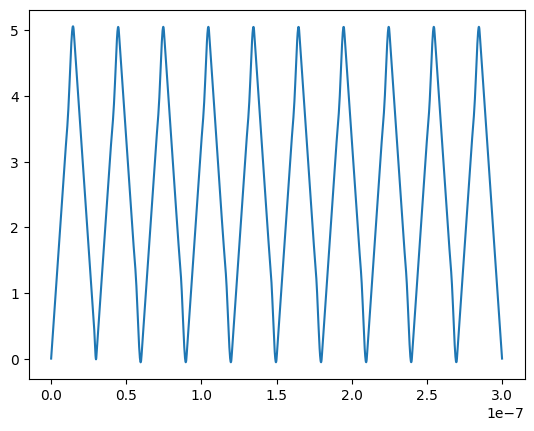

In [195]:
from scipy.interpolate import interp1d
tnu = df2.time.to_numpy()
V2 = df2.Vout.to_numpy()

# 2. Crear nuevo eje de tiempo uniforme QUE NO EXCEDA EL RANGO ORIGINAL
dt_uniforme = np.mean(np.diff(tnu))  # o define manualmente
t_uniforme = np.linspace(tnu[0], tnu[-1], num=10*len(tnu))

interpolador = interp1d(tnu, V2, kind='cubic')  # 'linear' o 'cubic'
V2_uniforme = interpolador(t_uniforme)

fig,ax = plt.subplots()

x = np.arange(0, len(V2), 1)

ax.plot(t_uniforme, V2_uniforme)

plt.show()

el nuevo dt despues de la interpolacion:

In [183]:
dt = t_uniforme[1]-t_uniforme[0]
print (dt)


1.7251293847038526e-10


calculo fft y freqs

In [196]:
# FFT con ventana de Hann para reducir leakage
N= len(V2_uniforme)
V2_fft = np.fft.fft(V2_uniforme)
frecuencias = np.fft.fftfreq(N, d=dt)


plot del espectro de freqs

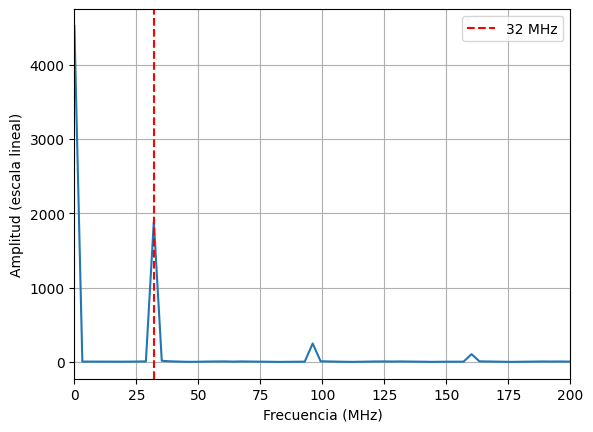

In [197]:
# Grafica el espectro (solo frecuencias positivas)
n_positivas = N // 2
plt.plot(frecuencias[:n_positivas]/1e6, np.abs(V2_fft[:n_positivas]))
plt.axvline(32, color='r', linestyle='--', label='32 MHz')
plt.xlabel('Frecuencia (MHz)')
plt.ylabel('Amplitud (escala lineal)')
plt.xlim(0, 200)  # Zoom en los primeros armónicos
plt.legend()
plt.grid()
plt.show()

recostruyo la señal:

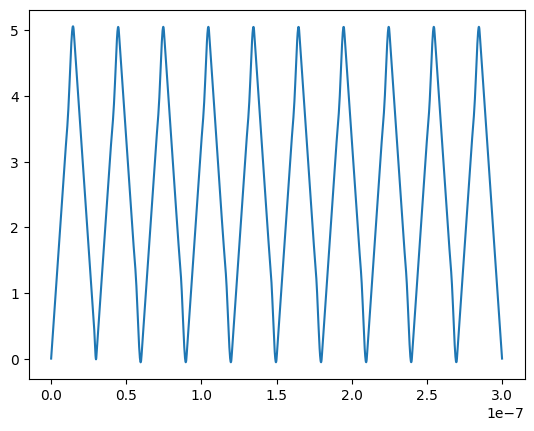

In [198]:
V2_rec = np.real(ifft(V2_fft))

fig,ax = plt.subplots()
x = np.arange(0, len(V2), 1)
ax.plot(t_uniforme, V2_rec)
plt.show()


Habiendo asegurado que la señal esta bien reconstruida, paso a aplicarle el filtro a la señal:

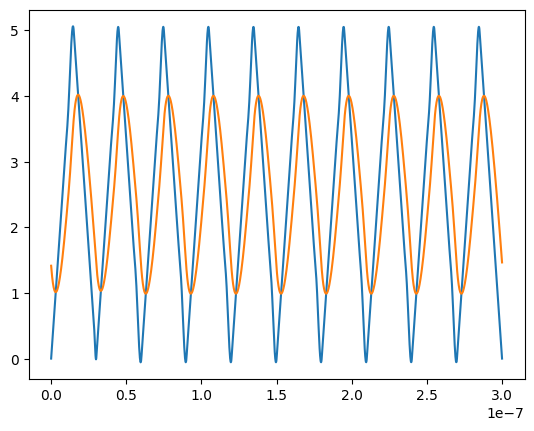

In [199]:
fc= 32e6 # 32Mhz

H = np.ones_like(frecuencias, dtype=complex)  # Inicializa H en 1 para ω=0

H = 1.0 / (1 + (1j *(frecuencias/fc)) )

# Aplica el filtro en el dominio de la frecuencia
V1_fft = V2_fft * H


V1 = np.real( ifft(V1_fft) )


fig,ax = plt.subplots()

x = np.arange(0, len(V2), 1)

ax.plot(t_uniforme, V2_rec)

ax.plot(t_uniforme, V1)

plt.show()
